## 02. Creating a Major Merger (MM) catalogue to study AGN incidence due to galaxy mergers

The notebook is divided into the following sections:
1. Loading data and defining input parameters
2. Creating a Major Merger sample (MM) and finding pairs
2. Studying merger fraction $f_{MM}$ as a function of redshift

**Script written by**: Soumya Shreeram <br>
**Project supervised by**: Johan Comparat <br>
**Date**: 30th March 2021

Import required packages

In [1]:
# scipy modules
from scipy.spatial import cKDTree
from scipy.interpolate import interp1d

# astropy modules
import astropy.units as u
import astropy.io.fits as fits

from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM, z_at_value

import numpy as np

# system imports
import os
import sys
import importlib as ib

# plotting imports
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

Load the imported file(s) that contains all the functions used in this notebooks

In [2]:
%matplotlib inline
font = {'family' : 'serif',
        'weight' : 'medium',
        'size'   : 20}
matplotlib.rc('font', **font)

In [3]:
sys.path.append('imported_files/')
import Exploring_DM_Halos as edh
import Agn_incidence_from_Major_Mergers as aimm
import plotting_aimm02 as pt
import All_sky as sky

### 1. Defining input parameters

In [4]:
# look back into redshifts until...
redshift_limit = 1.5

# agn parameters
agn_FX_soft = 0

# galaxy parameters
galaxy_SMHMR_mass = 8.5 # unit: log 10, M_solar

# halo parameters
halo_mass_500c = 10**13.7 # solar masses
central_Mvir = 13.7 # unit: log 10, M_solar
cluster_params = [halo_mass_500c, central_Mvir]

# array deciding the cuts in the merger times and their linestyles
t_merger_cut_arr, l = [1, 2.5, 5], ['-', '--', ':']

# pixel number from the simulation file
pixel_no = '000000'

# number of cluster files for the chosen pixel_no
clu_files_no = 3

# define color palatte
pal = sns.hls_palette(10, h=.5, s=1).as_hex()

Define cosmology used in the notebook

In [5]:
cosmo = FlatLambdaCDM(H0=67.77*u.km/u.s/u.Mpc, Om0=0.307115)
h = 0.6777
L_box = 1000.0 / h

# interpolation function of z -> distance (depends on cosmology)
redshift_step = 0.0001
z_array = np.arange(0,redshift_limit+0.1, step=redshift_step)
f_z_to_comoving_dist = interp1d(z_array, cosmo.comoving_distance(z_array))

Parameters for creating the Major Merger catalogue.

In [6]:
# ratio of masses to call a merger a major merger
mass_ratio_for_MM = 4

# time since merger [Gyr]
time_since_merger = 5

# time since merger array
dt_m_arr = [1, 2, 3, 4]

### 2. Open files and get relevant data

In [7]:
hd_agn, hd_halo, hd_clu = edh.getHeaders(pixel_no, np.array(['agn', 'halo', 'cluster']), clu_files_no=clu_files_no)

Extracting positions and redshifts of the AGNs, galaxies, and halos

In [8]:
# agns
pos_z_AGN, scale_merger_AGN, conditions_agn = edh.getAgnData(hd_agn, agn_FX_soft, redshift_limit)    

# galaxies and halos
pos_z_gal, scale_merger_gal, conditions_gal = edh.getGalaxyData(hd_halo, galaxy_SMHMR_mass, redshift_limit)
pos_z_halo, scale_merger_halo, conditions_halo = edh.getGalaxyData(hd_halo, '', redshift_limit)

print("AGNs: %d, Galaxies: %d, Halos: %d"%(len(pos_z_AGN[0]), len(pos_z_gal[0]), len(pos_z_halo[0]) ))

AGNs: 632718, Galaxies: 2916774, Halos: 2916774


### 3.  Creating a Major Merger sample i.e. finding pairs

For a defined time since merger $\Delta t_{merger}$ criteria, the following function in the code block gets all objects in defined merger mass bins, $\Delta m_{merger}$.

In [9]:
hd_mm_halo_all, num_mass_mm_halo = aimm.majorMergerSampleForAllMassBins(hd_halo, conditions_halo, galaxy_SMHMR_mass, mass_ratio_for_MM, cosmo, time_since_merger)
hd_mm_agn_all, num_mass_mm_agn = aimm.majorMergerSampleForAllMassBins(hd_agn, conditions_agn, galaxy_SMHMR_mass, mass_ratio_for_MM, cosmo, time_since_merger)

It is constructive to know how many samples of DM halos and AGNs were found in each mass bin before counting for pairs. The following plot is for $1\ {\rm pixel}^2 = 53\ {\rm deg}^2$ on the sky.

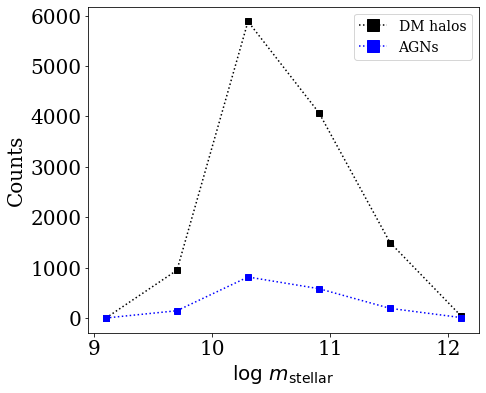

In [10]:
pt.plotCountsInMassBins(num_mass_mm_halo, num_mass_mm_agn)

Get pairs of DM halos and AGNs

In [12]:
num_pairs_halo_all, r_p, shell_volume = aimm.getNumberDensityOfPairs(hd_mm_halo_all)
num_pairs_agn_all, _, _ = aimm.getNumberDensityOfPairs(hd_mm_agn_all)

Plotting the distribution of the number density of pairs (normalized by the shell volume) as a function of the projected separation. The color scale shows the pairs found for a MM in different mass bins. As seen in the previous plot, we find none or few low mass ($10^{8.5-9.1} \ M_\odot$) and high mass ($10^{11.5-12.1} \ M_\odot$) major mergers in the chosen pixel.

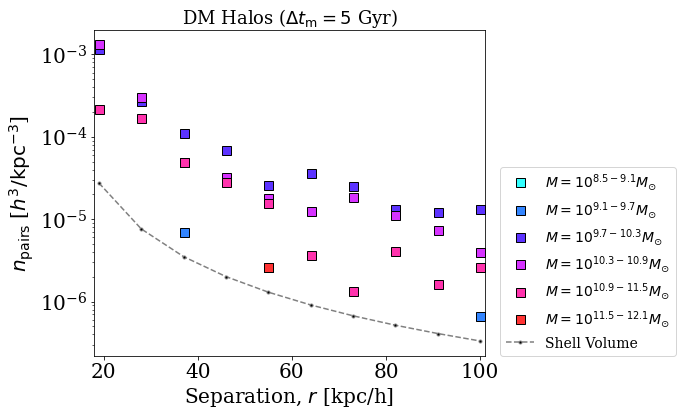

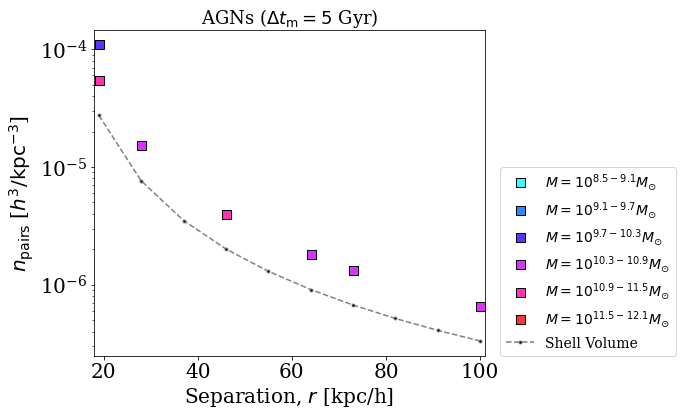

In [13]:
pt.plotNumberDensityVsRadius(num_pairs_halo_all, num_mass_mm_halo[1], pal, r'DM Halos ($\Delta t_{\rm m} = %d$ Gyr)'%time_since_merger)
pt.plotNumberDensityVsRadius(num_pairs_agn_all, num_mass_mm_agn[1], pal, r'AGNs ($\Delta t_{\rm m} = %d$ Gyr)'%time_since_merger) 

### 4. Studying the effect of $\Delta t_{\rm merger}$ on MM pairs

The following code block outputs pairs information by losing the mass bin information (all mass bins for a given $t_{\rm merger}$ are concatenated).

In [15]:
num_pairs_halo_dt_m, _ = aimm.studyTimeSinceMergerEffects(hd_halo, conditions_halo, cosmo, dt_m_arr)
num_pairs_agn_dt_m, _ = aimm.studyTimeSinceMergerEffects(hd_agn, conditions_agn, cosmo, dt_m_arr)

The following code block outputs pairs information by accounting for the mass bin information (all mass bins for a given $t_{\rm merger}$ are *not* concatenated).

In [19]:
_, num_pairs_halo_mass_dt_m = aimm.studyTimeSinceMergerEffects(hd_halo, conditions_halo, cosmo, dt_m_arr)
_, num_pairs_agn_mass_dt_m = aimm.studyTimeSinceMergerEffects(hd_agn, conditions_agn, cosmo, dt_m_arr)

Plotting the number density as a function of separation for different merger timescales for **DM halos**.

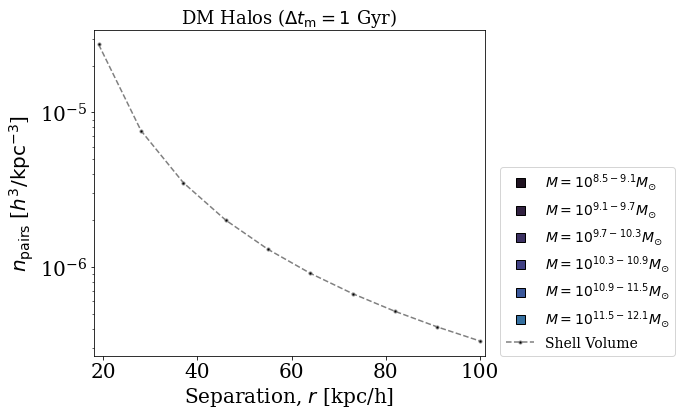

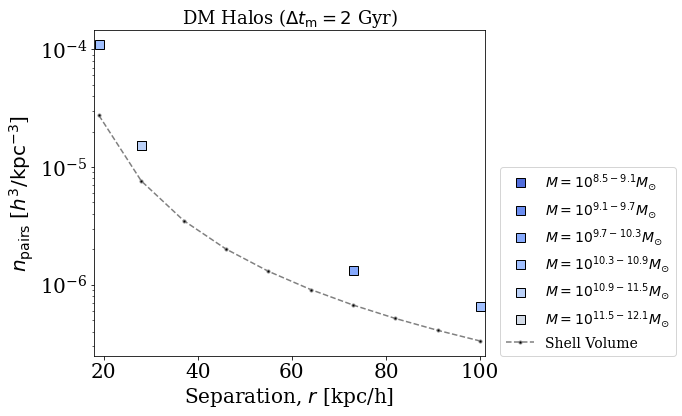

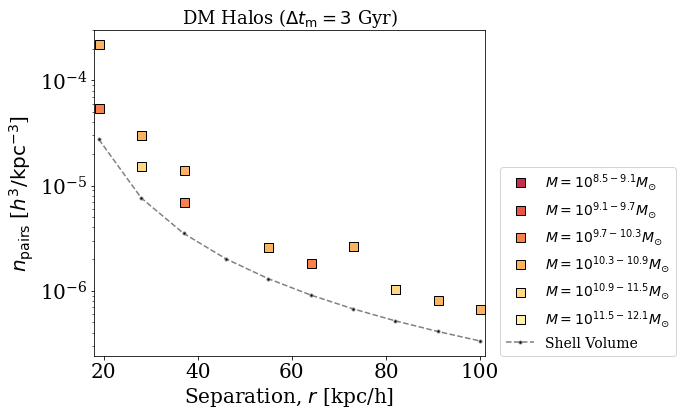

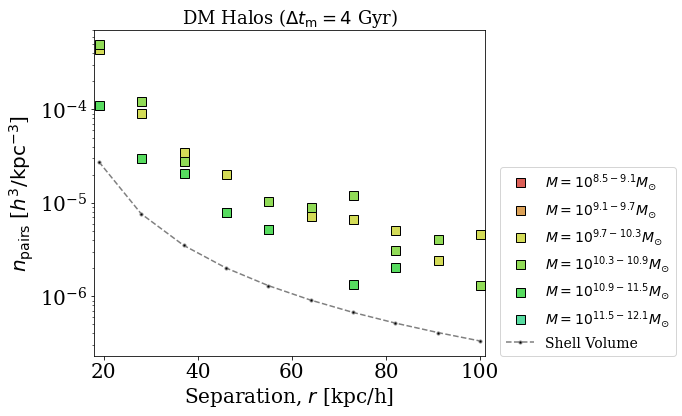

In [95]:
pt.plotTimeSinceMergerMassBins(dt_m_arr,  num_mass_mm_halo[1], num_pairs_halo_mass_dt_m)

Plotting the number density as a function of separation for different merger timescales for **AGN**.

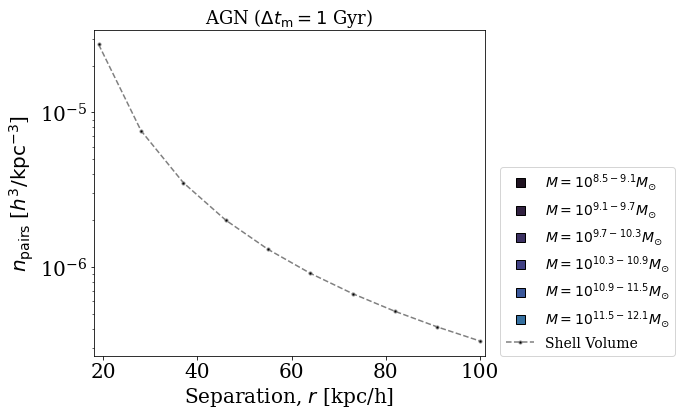

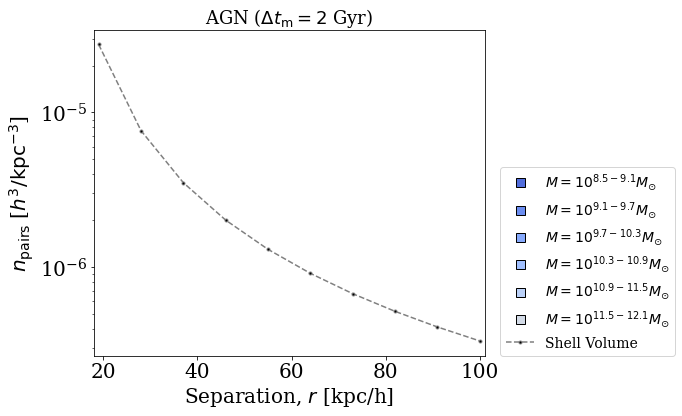

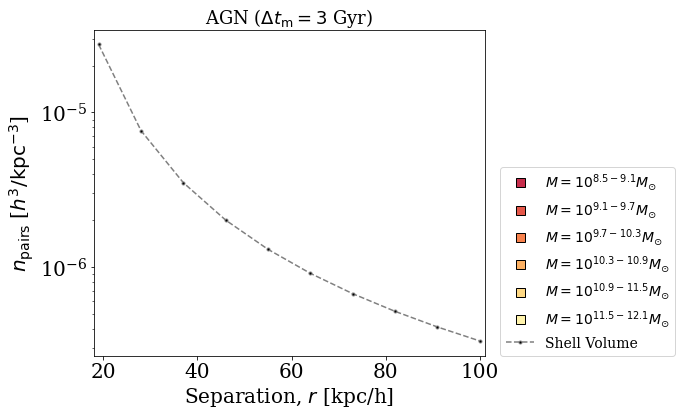

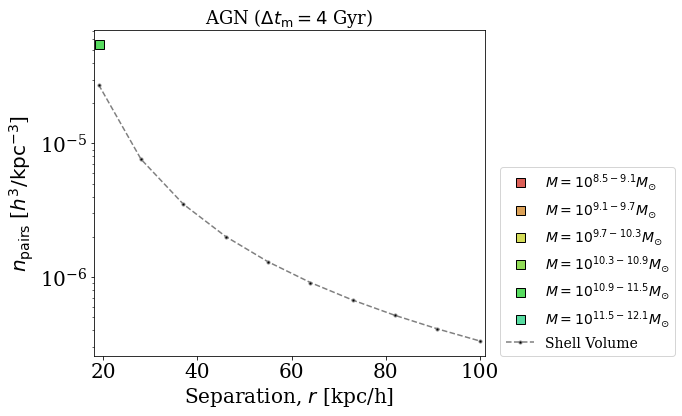

In [99]:
pt.plotTimeSinceMergerMassBins(dt_m_arr,  num_mass_mm_agn[1], num_pairs_agn_mass_dt_m, title="AGN")

Insight onto the distribution of $n_{\rm pairs}\ [{\rm h/kpc}]^{3}$ found for all the MM pairs. It is observed that as $\Delta t_{\rm m}$ increased, more MM pairs are found in the simulation. However, this is prominent only for $n_{\rm pairs}\ \sim 10^{-5}$ for DM halos. 

For AGNs, as observed in the last plot only 1 MM pair was found for at $r\sim 20$ kpc/h. Hence no bins could be formed.

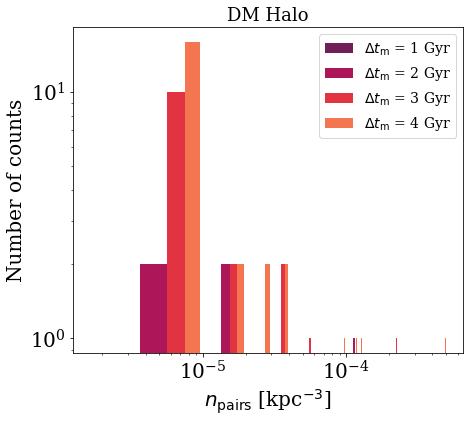

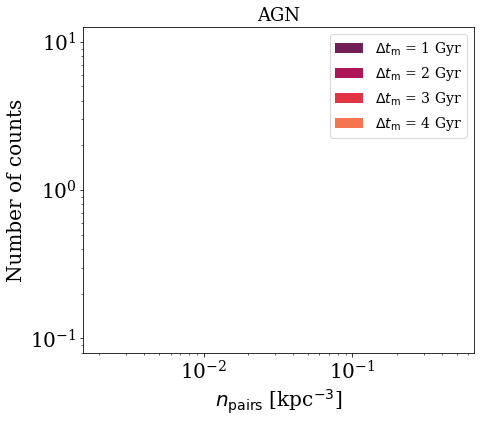

In [16]:
pt.plotEffectOfTimeSinceMerger(num_pairs_halo_dt_m, dt_m_arr, 'DM Halo')
pt.plotEffectOfTimeSinceMerger(num_pairs_agn_dt_m, dt_m_arr, 'AGN', binsize=50)

It seems that the criteria of binning masses is not succesful in finding pairs. Therefore, notebook 3 explores pair finding success when the mass bins criteria is taken off (i.e. we consider minor mergers as well). But first, the analysis from above is carried out on more simulation files from the sky.

### 5. Creating a bigger MM sample

The following code block produces a MM catalog, considering each defined mass bins, for $25$ pixels. This is to have better statistics of halos and AGN to generate plots shown above.

[====================] 100%

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


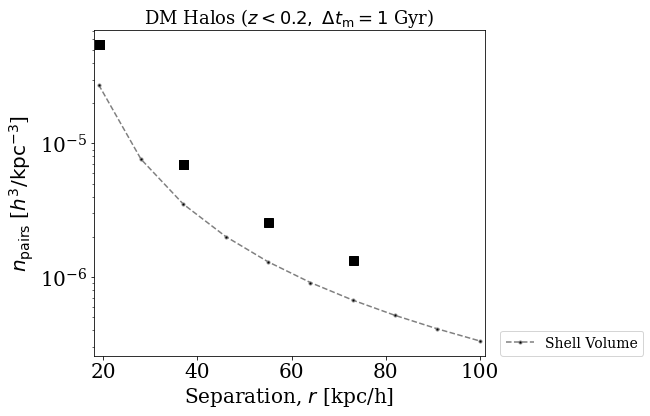

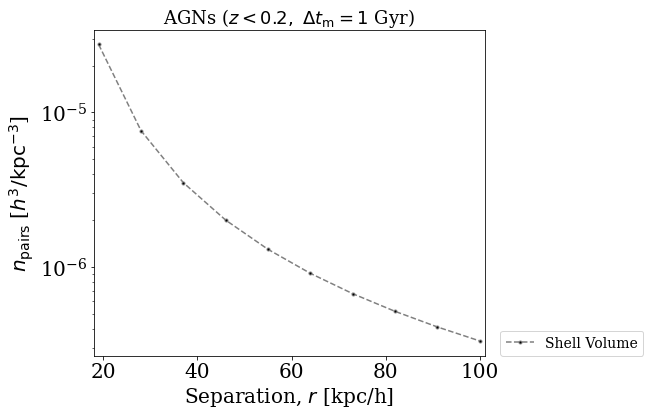

In [6]:
sky.countPairsAllSky(z=0.2, t=1)

[====================] 100%

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


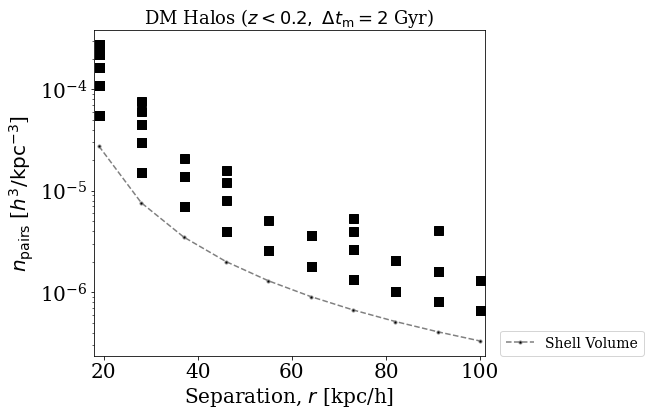

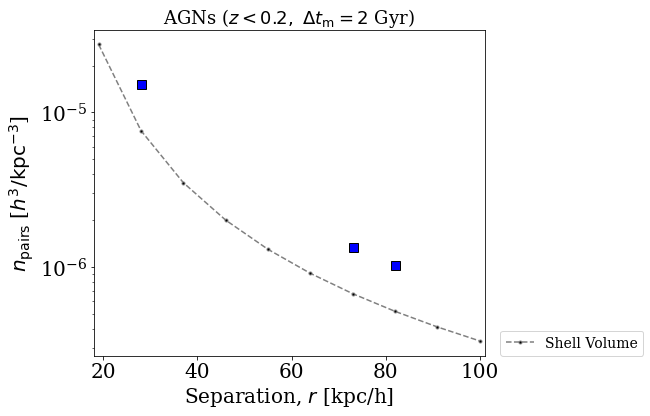

In [257]:
sky.countPairsAllSky(z=0.2, t=2.5)

[====================] 100%

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


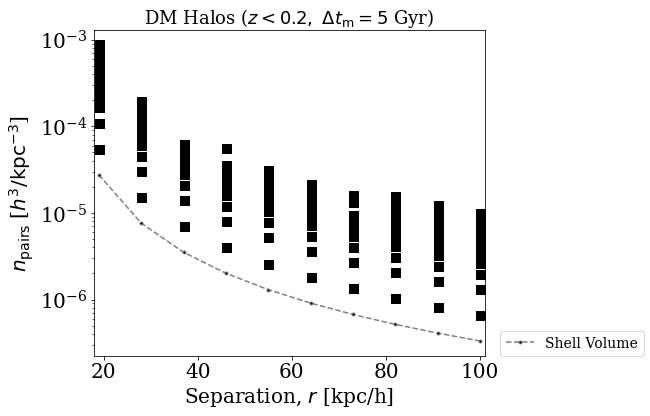

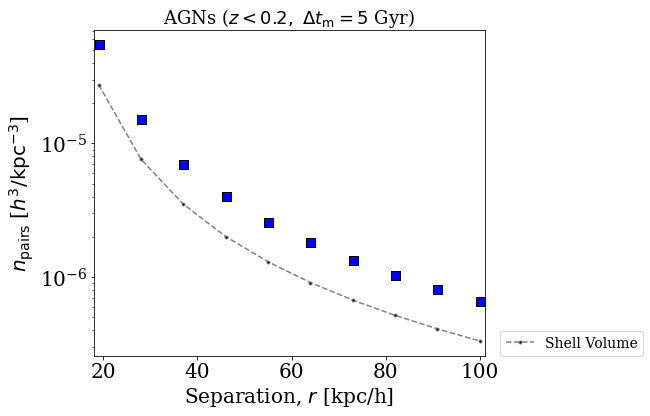

In [258]:
sky.countPairsAllSky(z=0.2, t=5)

[====================] 100%

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


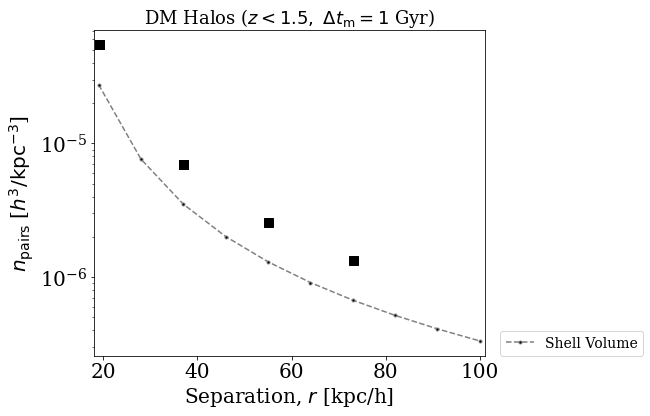

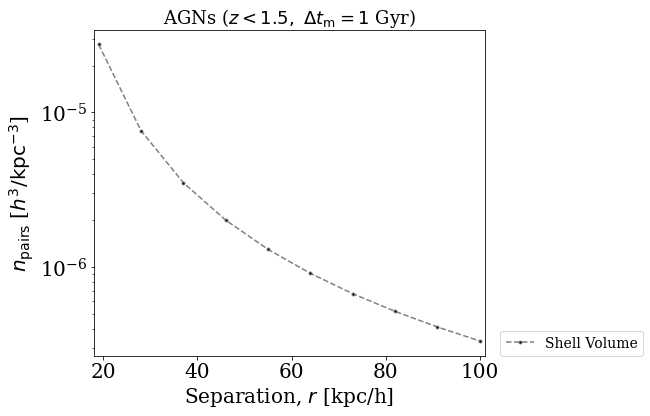

In [259]:
sky.countPairsAllSky(z=1.5, t=1)

[====================] 100%

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


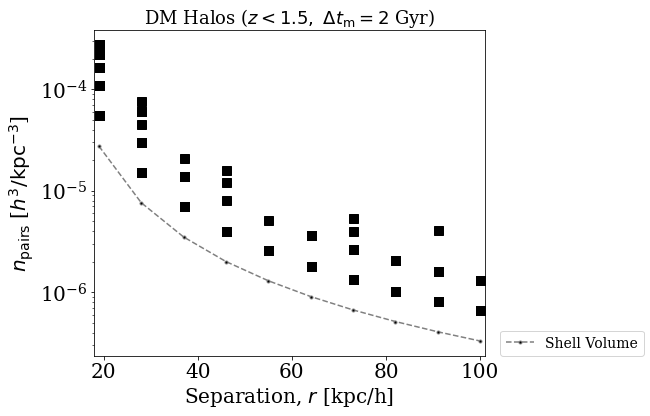

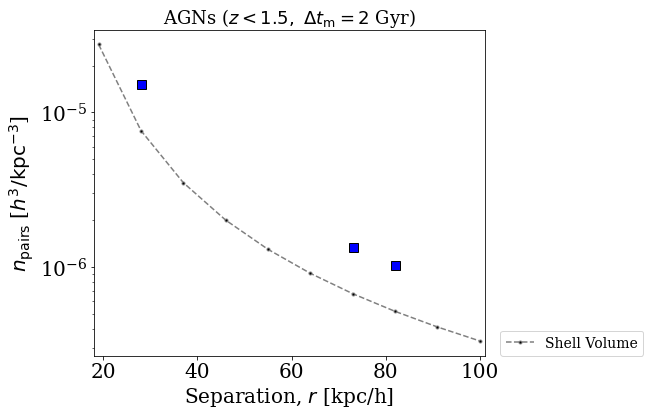

In [260]:
sky.countPairsAllSky(z=1.5, t=2.5)

[====================] 100%

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


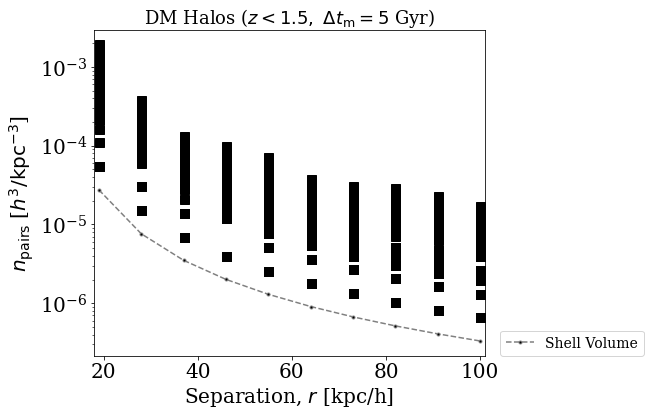

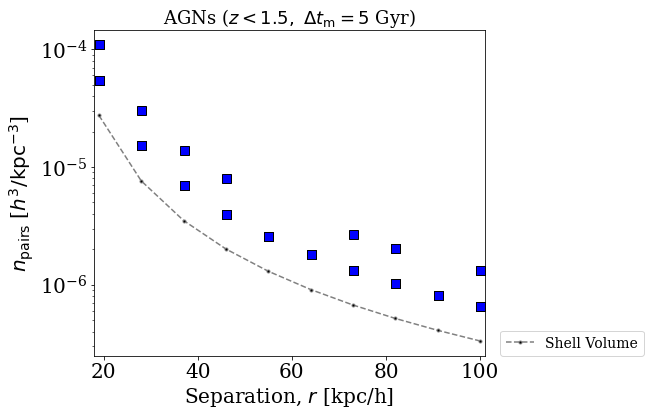

In [261]:
sky.countPairsAllSky(z=1.5, t=5)